# 🏠 Guide to your first competition - House Prices

This was my first real attempt at a Kaggle competition and it was a great learning exerpience. Hopefully this notebook will show you how to tackle competitions.  
The notebook is divided into the following sections:  
1 - EDA  
2 - Cleaning  
3 - Modelling  

# Imports and config

In [1]:
# Essentials
import numpy as np
import scipy
import pandas as pd
import datetime
import random
from scipy import stats
from scipy.stats import kstest
from scipy.stats import boxcox

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import yeojohnson

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

# Date loading

In [2]:
def read_data():
    """
    Read in train and test data
    
    Args:
        None
        
    Returns:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    """
    
    # Read in the dataset as a dataframe
    train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
    test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
    
    return train, test

train, test = read_data()
train.shape, test.shape

((1460, 81), (1459, 80))

# EDA

Let's first preview the data.

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## SalePrice : the target

The saleprice is what we are trying to predict, so let's have a look at a plot of this.

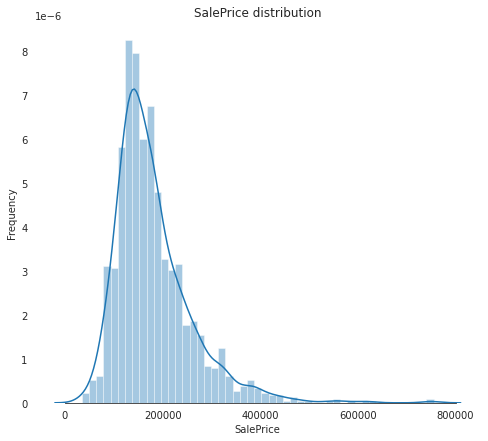

In [4]:
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
figure, ax = plt.subplots(figsize = (8, 7))
sns.distplot(train["SalePrice"])
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)  # remove left border from plot
plt.show()

The distribution looks quite skewed, lets measure its skewness and kurtosis.

In [5]:
print("Skewness: {}".format(train["SalePrice"].skew()))
print("Kurtosis: {}".format(train["SalePrice"].kurtosis()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


A relatively skewed distribution large tails.

## Features

Let's plot the features against the target, to see get a good feel for them.

In [6]:
def find_numeric_features(features):
    """
    Find numeric features of a given feature set
    
    Args:
        features (pandas dataframe) : dataframe to inspect
        
    Returns:
        numeric (string[]) : numeric feature names 
    
    """
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    return numeric

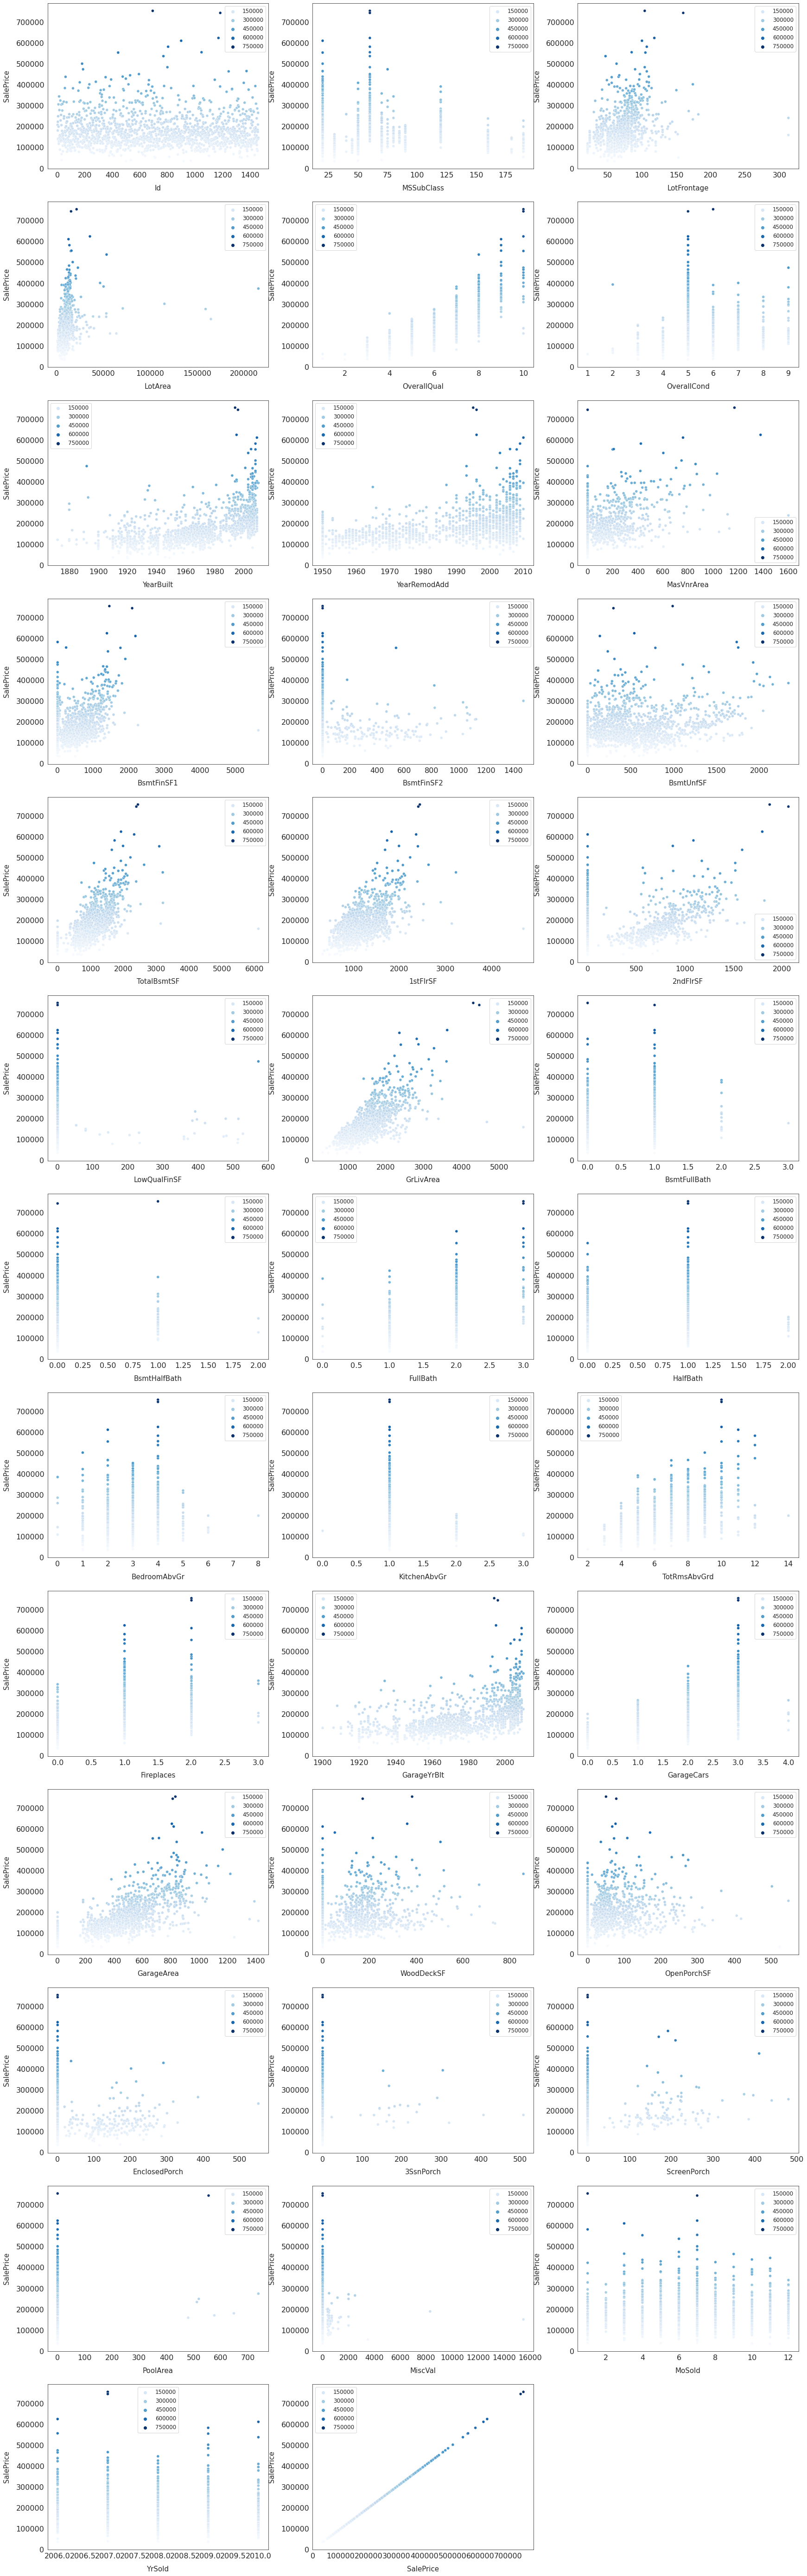

In [7]:
def plot_features_against_target(data):
    """
    Create scatter subplots of all features against target
    
    Args:
        data (pandas dataframe) : data whose features we want to plot
        
    Returns:
        None
    """

    # Finding numeric features
    numeric = find_numeric_features(data)         

    # define figure
    fig, axs = plt.subplots(ncols=3, figsize=(12, 120))

    # adjust spacing
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)

    # set colour palette
    sns.color_palette("husl", 8)

    # for each feature
    for i, feature in enumerate(list(data[numeric]), 1):

        # plot data
        plt.subplot(len(list(numeric)), 3, i)
        sns.scatterplot(x = feature, y='SalePrice', hue='SalePrice', palette='Blues', data = data)

        # add axis labels
        plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        # change tick sizes
        plt.tick_params(axis='x', labelsize=16)
        plt.tick_params(axis='y', labelsize=16)

        # add legend
        plt.legend(loc='best', prop={'size': 12})

    plt.show()
    
plot_features_against_target(train)

We see that certain features like 'TotalBsmtSF' and 'GrLivArea' are strongly correlated with 'SalePrice'. Other features like 'BsmtFinSF2' have alsmost no correlation. There is also clearly a lot of outliers and corrupt data to remove.

Let's now plot a correlation heat map to see how features are correlated to each other and to SalePrice.

<AxesSubplot:>

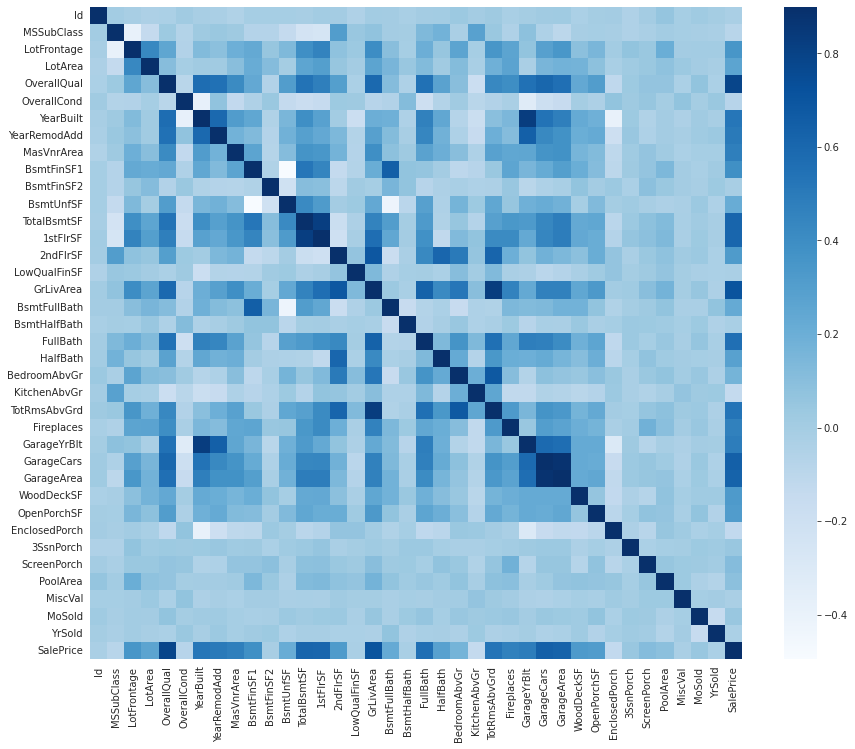

In [8]:
corr = train.corr()
plt.subplots(figsize = (15, 12))
sns.heatmap(corr, vmax = 0.9, cmap = 'Blues', square = True)

We see some strong correlations here, some more useful than others. For example, "GarageYrBlt" being strongly correlated with "YearBuilt" is not a surprising relationship.

Let's look at how some specfic features are correlated with the target.

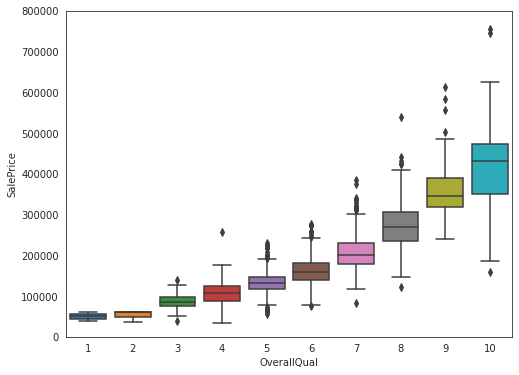

In [9]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

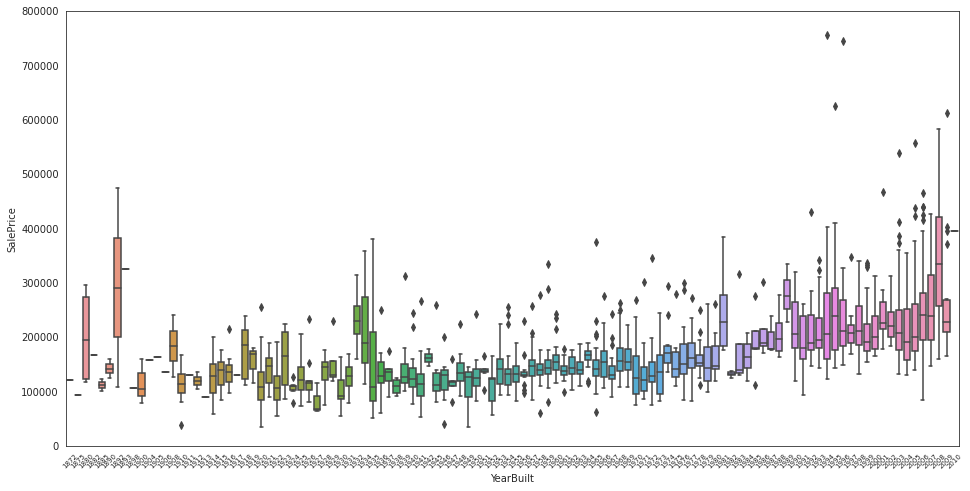

In [10]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);
plt.tick_params(axis='x', labelsize=7)

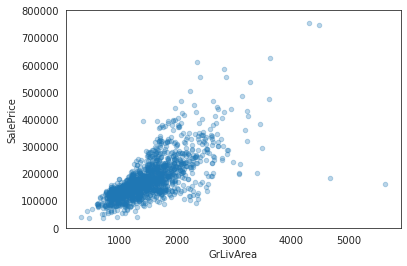

In [11]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

# Data Cleaning

First we will remove the Ids from the train and test, as they are unique for each row and hence not useful for the model.

In [12]:
def drop_ID(X):
    """
    Drop the ID column since it is unique and so useless for ML
    
    Args:
        X (pandas dataframe) : dataframe whose ID col we want to trop
    
    Returns:
        X (pandas dataframe) : dataframe with ID's dropped
    """
    X.drop(['Id'], axis = 1, inplace = True)
    return X

train = drop_ID(train)
test = drop_ID(test)
train.shape, test.shape

((1460, 80), (1459, 79))

Now, lets look at the SalePrice distribution again.

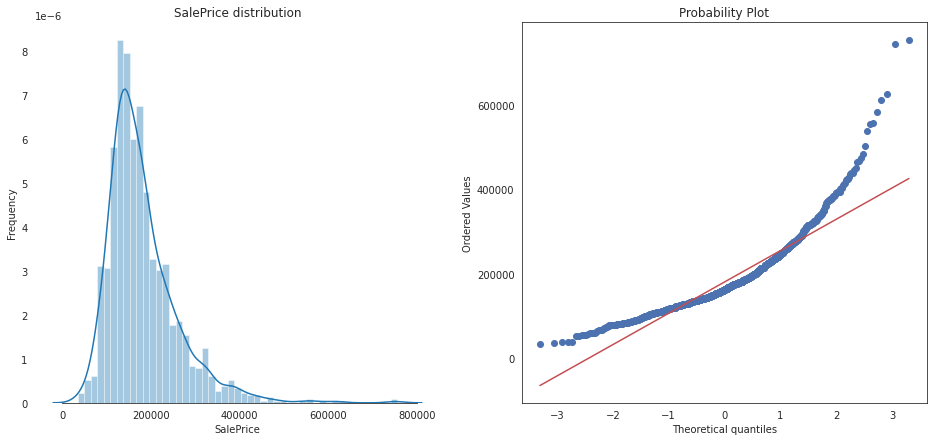

In [13]:
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
figure = plt.subplots(figsize = (16, 7))

# histogram
plt.subplot(1, 2, 1)
sns.distplot(train["SalePrice"])
plt.ylabel("Frequency")
plt.xlabel(xlabel = "SalePrice")
plt.title("SalePrice distribution")
sns.despine(trim = True, left = True)  # remove left border from plot

# probability plot
plt.subplot(1, 2, 2)
stats.probplot(train["SalePrice"], dist="norm", plot=plt)

plt.show()

Notice that it is skewed to the right. This is bad as models do not work well with skewed data. In order to make it more normal, apply a $\ln({1+x})$ transform.

In [14]:
def transform_target(X):
    """
    Transform target to make it normally distributed
    
    Params:
        X (pandas dataframe) : dataframe whose target we want to transform
        
    Returns:
        X (pandas dataframe) : transformed dataframe
    """
    X["SalePrice"] = np.log1p(X["SalePrice"])
    return X

# log(1+x) transform
train = transform_target(train)

Now replot the distrubition alongside a fitted normal distribution to see how they compare.

mu = 12.02
sigma = 0.40


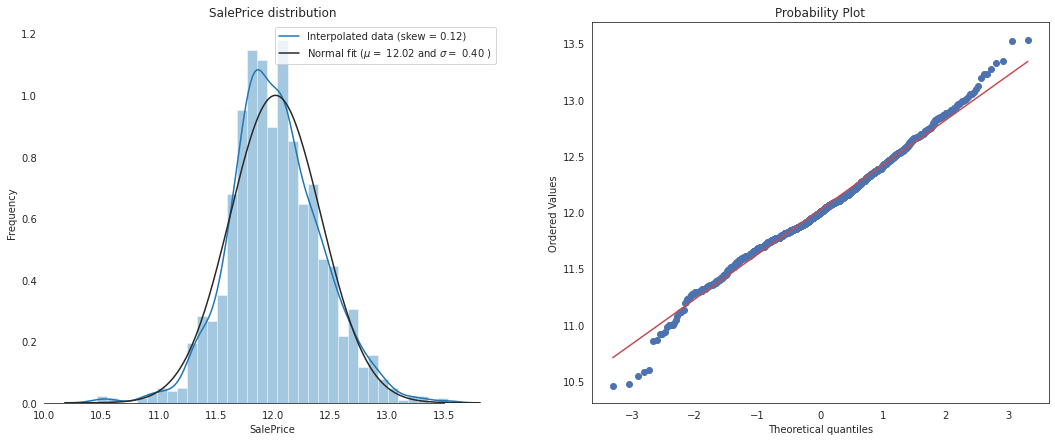

In [15]:
# set up figure
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
figure, ax = plt.subplots(figsize = (18, 7))

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
s = skew(train["SalePrice"])
print('mu = {:.2f}'.format(mu))
print('sigma = {:.2f}'.format(sigma))

# histogram
plt.subplot(1, 2, 1)
sns.distplot(train["SalePrice"], fit = norm)
plt.legend(["Interpolated data (skew = {:.2f})".format(s),'Normal fit ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)])
plt.ylabel("Frequency")
plt.xlabel("SalePrice")
plt.title("SalePrice distribution")
sns.despine(trim = True, left = True)  # remove left border from plot

# probability plot
plt.subplot(1, 2, 2)
stats.probplot(train["SalePrice"], dist = 'norm', plot = plt)

plt.show()

The target is no longer skewed.

## Drop outliers

Using the plots we made before of specific features against the SalePrice, we will remove some of the outliers.

In [16]:
def drop_outliers(X):
    """
    Drop any identified outliers
    
    Args:
        X (pandas dataframe) : dataframe whose outliers we want to drop
        
    Returns:
        X (pandas dataframe) : dataframe with outliers dropped
    """
    X.drop(X[(X['OverallQual'] < 5) & (X['SalePrice'] > 200000)].index, inplace=True)
    X.drop(X[(X['GrLivArea'] > 4500) & (X['SalePrice'] < 300000)].index, inplace=True)
    X.reset_index(drop=True, inplace=True) # restores index after dropping
    return X

train = drop_outliers(train)

## Drop target

We drop the target before continuing.

In [17]:
def drop_target(train):
    """
    Drop the target from the train data
    
    Args:
        train (pandas dataframe) : train data
        
    Returns:
        train (pandas dataframe) : train data with target dropped
        y_train (pandas series) : target
    """
    y_train = train['SalePrice'].reset_index(drop=True)
    train = train.drop(['SalePrice'], axis=1) # drop the target
    return y_train, train

y_train, train = drop_target(train)

## Prepare dataset for cleaning

We define functions for combining and splitting the train and test data which will be useful for cleaning.

In [18]:
def combine_train_and_test(train, test):
    """
    Prepare datasets for cleaning by dropping target and combining into one dataset
    
    Args:
        train (pandas dataframe) : train dataset
        test (pandas dataframe) : test dataset
    
    Returns:
        X (pandas dataframe) : combined data
    """
    X = pd.concat([train, test]).reset_index(drop=True) # combine train and test
    
    return X

X = combine_train_and_test(train, test)
X.shape

(2917, 79)

In [19]:
def split_train_and_test(X, target):
    """
    Extract the train and test sets from the combined data
    
    Args:
        X (pandas dataframe) : dataframe to split up
        target (pandas series) : target data
        
    Return:
        X_test (pandas dataframe) : test data
        X_train (pandas dataframe) : train data
    """
    X_train = X.iloc[:len(y_train), :]
    X_test = X.iloc[len(y_train):, :]
    return X_train, X_test

In [20]:
def correct_feature_type(X):
    """
    Some features are mistyped as numeric when they should be categorical
    
    Args:
        X (pandas dataframe) : dataframe with types to convert
        
    Returns:
        X (pandas dataframe) : dataframe with types corrected
    """
    # some numerical features are really categorical features
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['OverallCond'] = X['OverallCond'].astype(str)
    X['YrSold'] = X['YrSold'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)
    
    return X

X = correct_feature_type(X)

## Fill missing values

First, lets print the percentage of missing values from each column.

In [21]:
def percent_missing(data):
    """
    Characterise missing data in a dataframe
    
    Args:
        df (pandas dataframe) : dataframe we want to inspect
    
    Returns:
        miss_df()
    """
    miss_df = ((data == 0).sum()).to_frame()
    miss_df = miss_df.rename(columns = {0: 'zeros'})
    miss_df.index.name = 'Feature'
    miss_df['np.nan'] = (data.isnull()).sum()
    miss_df['None'] = (data == "None").sum()
    miss_df['total'] = miss_df['zeros'] + miss_df['np.nan'] + miss_df['None']
    miss_df['Percent'] = 100*miss_df['total']/len(data)
    miss_df['Type'] = [data[i].dtype for i in miss_df.index ]
    return miss_df.sort_values(ascending = False, by = 'Percent')

miss_all = percent_missing(X)
miss_all.head()

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
PoolQC,0,2908,0,2908,99.691464,object
PoolArea,2905,0,0,2905,99.588618,int64
3SsnPorch,2880,0,0,2880,98.731574,int64
LowQualFinSF,2877,0,0,2877,98.628728,int64
MiscVal,2814,0,0,2814,96.468975,int64


We see that there are a few columns with lots of missing data.  
Let's visualise this data.

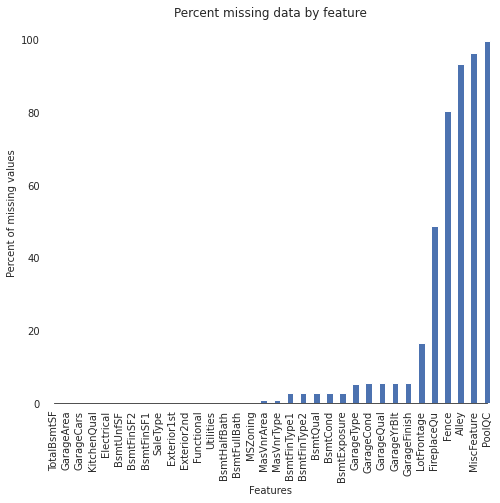

In [22]:
# set up figure with colour formatting
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

# determine columns with more than one missing value and sort in increasing orber
missing = round(X.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

# tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

Now we want to impute missing values for each of these features.

In [23]:
def handle_missing(X):
    """
    Handle all missing features
    
    Args:
        X (pandas dataframe) : data to remove missing values
        
    Returns: 
        X (pandas dataframe) : data with missing values removed
    """
    # the data description states that NA refers to typical ('Typ') values
    X['Functional'] = X['Functional'].fillna('Typ')
    
    # Replace the missing values in each of the columns below with their mode
    X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode())
    X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode())
    X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode())
    X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode())
    X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode())
    
    # zoning is likely based on subclass so we fill based on the mode in that zone
    X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    X["PoolQC"] = X["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        X[col] = X[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        X[col] = X[col].fillna('None')
    # NaN values for these categorical basement X, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        X[col] = X[col].fillna('None')
        
    # lot frontage likely based on neighbourhood so fill based on median in neighbourhood
    X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    # We have no particular intuition around how to fill in the rest of the categorical X
    # So we replace their missing values with None
    objects = []
    for i in X.columns:
        if X[i].dtype == object:
            objects.append(i)
    X.update(X[objects].fillna('None'))
    
    # And we do the same thing for numerical X, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in X.columns:
        if X[i].dtype in numeric_dtypes:
            numeric.append(i)
    X.update(X[numeric].fillna(0))    
    return X
    
X = handle_missing(X)

Let's now check that we have handled all the missing features.

In [24]:
missing = percent_missing(X)
missing.head()

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
PoolQC,0,0,2908,2908,99.691464,object
PoolArea,2905,0,0,2905,99.588618,int64
3SsnPorch,2880,0,0,2880,98.731574,int64
LowQualFinSF,2877,0,0,2877,98.628728,int64
MiscVal,2814,0,0,2814,96.468975,int64


As desired, there are no missing values anymore.

## Fix skewed features

Models struggle to deal with non normally distributed features, so we want to transform these in some way.  
Lets plot the numeric features.

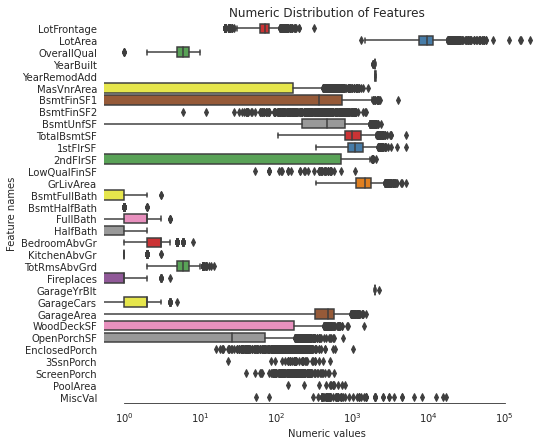

In [25]:
def plot_numeric_feature_distributions(features):
    """
    Create boxplot distribution of numeric features
    
    Args:
        features (pandas dataframe) : dataframe to inspect
        
    Returns:
        None
    """

    # set up figure
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.set_xscale("log")

    # find numeric features and plot
    numeric = find_numeric_features(features)
    ax = sns.boxplot(data = features[numeric] , orient="h", palette="Set1")

    # edit figure
    ax.xaxis.grid(False)
    ax.set(ylabel="Feature names")
    ax.set(xlabel="Numeric values")
    ax.set(title="Numeric Distribution of Features")
    sns.despine(trim=True, left=True)
    
plot_numeric_feature_distributions(X)

Let's set a cutoff of skew = 0.5 and find features with a high skewness.

In [26]:
def find_skewed_features(features, cutoff):
    """
    Determine all features which are skewed above some threshold
    
    Args:
        features (pandas dataframe) : dataframe to inspect
        cutoff (int) : minimum skew
        
    Returns
        skew_features (pandas series) : skewness of each numeric feature
        high_skew_index (pandas index) : names of high skew features
    
    """
    
    numeric = find_numeric_features(features) # get numeric features
    skew_features = features[numeric].apply(lambda x : skew(x)).sort_values(ascending = False) # find skewed features and sort
    high_skew = skew_features[skew_features > skew_cutoff] # filter by skew cutoff
    high_skew_index = high_skew.index
    return high_skew, high_skew_index

In [27]:
skew_cutoff = 0.5
skew_features, high_skew_index = find_skewed_features(X, skew_cutoff)

# print results
print("There are {} numerical features with a skew > {}:".format(skew_features.shape[0], skew_cutoff))
skew_features.head(10)

There are 24 numerical features with a skew > 0.5:


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

We can use boxcox1 function to compute the Box-Cox transformation.

In [28]:
def fix_skewed_features(X):
    """
    Find then fix skewed features
    
    Args:
        X (pandas dataframe) : dataframe whose skewed features we want to fix
        
    Returns
        X (pandas dataframe) : dataframe with skewed features fixed
    """
    
    # find all skewed features
    kew_cutoff = 0.5
    skew_features, high_skew_index = find_skewed_features(X, skew_cutoff)
    
    # transform features
    for i in high_skew_index:
        #X[i] = 1/X[i]
        #X[i] = np.sqrt(X[i])
        #X[i] = np.log1p(X[i])
        #X[i] = yeojohnson(X[i])[0]
        X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))
        
    return X

X = fix_skewed_features(X)

Let's plot the numeric features again and see if we have corrected the skewness.

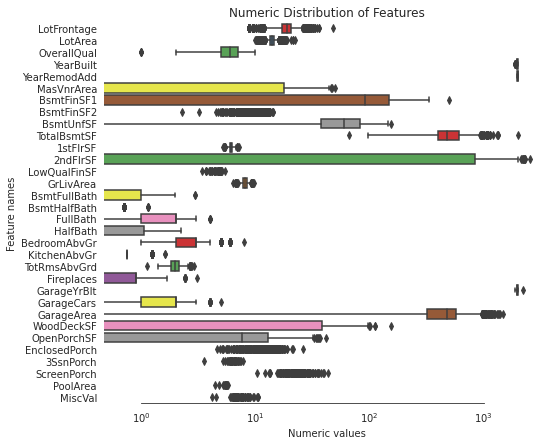

In [29]:
plot_numeric_feature_distributions(X)

The features are much less skewed now.

In [30]:
skew_cutoff = 0.5
high_skew, high_skew_index = find_skewed_features(X, skew_cutoff)

# print results
print("There are {} numerical features with a skew > {}:".format(high_skew_index.shape[0], skew_cutoff))
high_skew.head(10)

There are 16 numerical features with a skew > 0.5:


PoolArea         15.595057
3SsnPorch         8.862045
LowQualFinSF      8.492615
MiscVal           5.237983
BsmtHalfBath      3.779434
KitchenAbvGr      3.778336
ScreenPorch       3.152631
BsmtFinSF2        2.578329
EnclosedPorch     2.149133
MasVnrArea        0.977618
dtype: float64

# Feature Engineering

## Creating features

ML models have trouble with complex features, so we will create some simpler ones using intution.

In [31]:
def create_new_features(X):
    """
    Create new features for the data
    
    Args:
        X (pandas dataframe) : dataframe which we want to determine new features for
    
    Returns:
        X (pandas dataframe) : dataframe with new features    
    """

    X = X.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

    X['YrBltAndRemod']=X['YearBuilt']+X['YearRemodAdd']
    X['TotalSF']=X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']

    X['Total_sqr_footage'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] +
                                     X['1stFlrSF'] + X['2ndFlrSF'])

    X['Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) +
                                   X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))

    X['Total_porch_sf'] = (X['OpenPorchSF'] + X['3SsnPorch'] +
                                  X['EnclosedPorch'] + X['ScreenPorch'] +
                                  X['WoodDeckSF'])



    X['haspool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    X['has2ndfloor'] = X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['hasgarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['hasbsmt'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['hasfireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return X

X = create_new_features(X)

## Feature transformations

ML models struggle to tell if log(feature) or (feature)^2 is a good predictor of the target, so we will manually add these.

In [32]:
def log_transform(features, log_features):
    """
    Use log transform on certain features and store them in the dataframe
    
    Args:
        features (pandas dataframe) : dataframe where new features will be stored
        log_features (string[]) : names of features to log transform
        
    Returns:
        features (pandas dataframe) : transformed dataframe
    """
    for log_feature in log_features:
        features[log_feature + '_log'] = np.log(1.01 + features[log_feature])
    return features

# get all features to log transform
log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

# apply log transform
X = log_transform(X, log_features)

In [33]:
def square_transform(features, squ_features):
    """
    Use square transform on certain features and store them in the dataframe
    
    Args:
        features (pandas dataframe) : dataframe where new features will be stored
        squ_features (string[]) : names of features to square transform
        
    Returns:
        features (pandas dataframe) : transformed dataframe
    """
    for squ_feature in squ_features:
        features[squ_feature + "_squ"] = features[squ_feature] * features[squ_feature]
    return features

# get all features to square transform
squared_features = ['YearRemodAdd', 'LotFrontage_log', 
                    'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
                    'GarageCars_log', 'GarageArea_log']

# apply square transform
X = square_transform(X, squared_features)

## Encode categorical features

Most models can only handle numerical features so we will convert our categorical features.

Some features maybe better to be ordinal encoded:

- ExterQual:-
    - Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- ExterCond:-
    - Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- BsmtQual:-
    - None : 0, Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- BsmtExposure:-
    - None : 0, No : 1, Mn : 2, Av : 3, Gd : 4
- BsmtFinType1:-
    - None : 0, Unf : 1, LwQ : 2, Rec : 3, BLQ : 4, ALQ : 5, GLQ : 6
- BsmtFinType2:-
    - None : 0, Unf : 1, LwQ : 2, Rec : 3, BLQ : 4, ALQ : 5, GLQ : 6
- HeatingQC:-
    - Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- KitchenQual:-
    - Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- GarageFinish:-
    - None : 0, Unf : 1, RFn : 2, Fin : 3

In [34]:
def encode_categorical(X):
    """
    Encode caletgorical features
    
    Args:
        X (pandas dataframe) : dataframe whose categorical features we want to encode
        
    Returns:
        X (pandas dataframe) : dataframe with categorical features encoded
    """
    X = pd.get_dummies(X).reset_index(drop = True)
    
    return X

X = encode_categorical(X)

In [35]:
X.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_squ,LotFrontage_log_squ,TotalBsmtSF_log_squ,1stFlrSF_log_squ,2ndFlrSF_log_squ,GrLivArea_log_squ,GarageCars_log_squ,GarageArea_log_squ,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtC

# Data pipeline

We know want to combine all of the above steps into a single pipeline function.

In [36]:
def data_pipeline():
    """
    Data pipeline to read, clean and engineer features
    
    Args:
        None
        
    Returns:
        X_train (pandas dataframe) : train data
        X_test (pandas dataframe) : test data
        y_train (pandas series) : target
    """
    # read in data
    train, test = read_data()

    # drop id column
    train = drop_ID(train)
    test = drop_ID(test)
    
    # transform the target to normalise
    train = transform_target(train)

    # drop outliers
    train = drop_outliers(train)
    
    # drop target
    y_train, train = drop_target(train)

    # extract target and combine train and test for cleaning
    X = combine_train_and_test(train, test)
    
    # correct feature types
    X = correct_feature_type(X)

    # fill all missing values
    X = handle_missing(X)

    # normalise skewed features
    X = fix_skewed_features(X)

    # create new features
    X = create_new_features(X)

    # log transform 
    log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                    'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                    'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                    'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                    'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']
    #X = log_transform(X, log_features)

    # square transform
    squared_features = ['YearRemodAdd', 'LotFrontage_log', 
                        'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
                        'GarageCars_log', 'GarageArea_log']
    #X = square_transform(X, squared_features)

    # encode categorical features
    X = encode_categorical(X)

    # decouple the train and test data
    train, test = split_train_and_test(X, y_train)

    return train, test, y_train

X_train, X_test, y_train = data_pipeline()
X_train.shape, X_test.shape, y_train.shape

((1458, 346), (1459, 346), (1458,))

In [37]:
X_train.isnull().values.any(), X_test.isnull().values.any(), y_train.isnull().values.any()

(False, False, False)

# Building a model

## Key features of training a model:
- **Cross Validation** Using 12-fold cross-validation
- **Models:** On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** In addition, I trained a meta StackingCVRegressor optimized using xgboost
- **Blending:** All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

## Setup cross validation and define error metrics

We will use a 12 fold validation.

In [38]:
kf = KFold(n_splits = 12, random_state = 42, shuffle = True)

The error metric we use is the root mean squared log error (rmsle).

In [39]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y):
    score = cross_val_score(
        model, X, y, cv=kf, scoring="neg_mean_squared_error",
    )
    score = np.sqrt(-score)
    score_mean = score.mean()
    score_std = score.std()
    return score_mean, score_std

## Setup models

Let's setup the models now. To begin with we will keep all hyperparameters to their default values. These can be tweaked later.

In [40]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=4,
                       learning_rate=0.01, 
                       n_estimators=5000,
                       max_bin=200, 
                       bagging_fraction=0.75,
                       bagging_freq=5, 
                       bagging_seed=7,
                       feature_fraction=0.2,
                       feature_fraction_seed=7,
                       verbose=-1)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3460,
                       max_depth=3, 
                       min_child_weight=0,
                       gamma=0, 
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', 
                       nthread=-1,
                       scale_pos_weight=1, 
                       seed=27,
                       reg_alpha=0.00006)

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

# Ridge Regressor
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kf))

# Lasso
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

# Elasticnet
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004,0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kf, l1_ratio=e_l1ratio))   

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42)  

# Random Forest Regressor
rf = RandomForestRegressor()

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Get cross validation scores

In [41]:
def score_models_individually(X_train, y_train):
    scores = {}

    # lightgbm
    score_mean, score_std = cv_rmse(lightgbm, X_train, y_train)
    print("lightgbm: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['lgb'] = (score_mean, score_std)

    # xgboost
    score_mean, score_std = cv_rmse(xgboost, X_train, y_train)
    print("xgboost: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['xgb'] = (score_mean, score_std)
    
    # svr
    score_mean, score_std = cv_rmse(svr, X_train, y_train)
    print("SVR: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['svr'] = (score_mean, score_std)

    # ridge
    score_mean, score_std = cv_rmse(ridge, X_train, y_train)
    print("ridge: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['ridge'] = (score_mean, score_std)
    
    # lasso
    score_mean, score_std = cv_rmse(lasso, X_train, y_train)
    print("lasso: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['ridge'] = (score_mean, score_std)
    
    # elasticnet
    score_mean, score_std = cv_rmse(elasticnet, X_train, y_train)
    print("elasticnet: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['ridge'] = (score_mean, score_std)
    
    # gbr
    score_mean, score_std = cv_rmse(gbr, X_train, y_train)
    print("gbr: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['gbr'] = (score_mean, score_std)

    # rf
    score_mean, score_std = cv_rmse(rf, X_train, y_train)
    print("rf: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['rf'] = (score_mean, score_std)
    
    return scores

scores = score_models_individually(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 w

## Fit the models

Now we fit all the models on the trainning data.

In [42]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

print('RandomForest')
rf_model_full_data = rf.fit(X_train, y_train)

stack_gen
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsa

## Blend models and get predictions

Finally we blend all of the models which make the predictions more robust to overfitting.

In [43]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

# Get final precitions from the blended model
blended_score = rmsle(y_train, blend_models_predict(X_train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.06156619202025178


Let's plot the scores of each of our models to see how they compare.

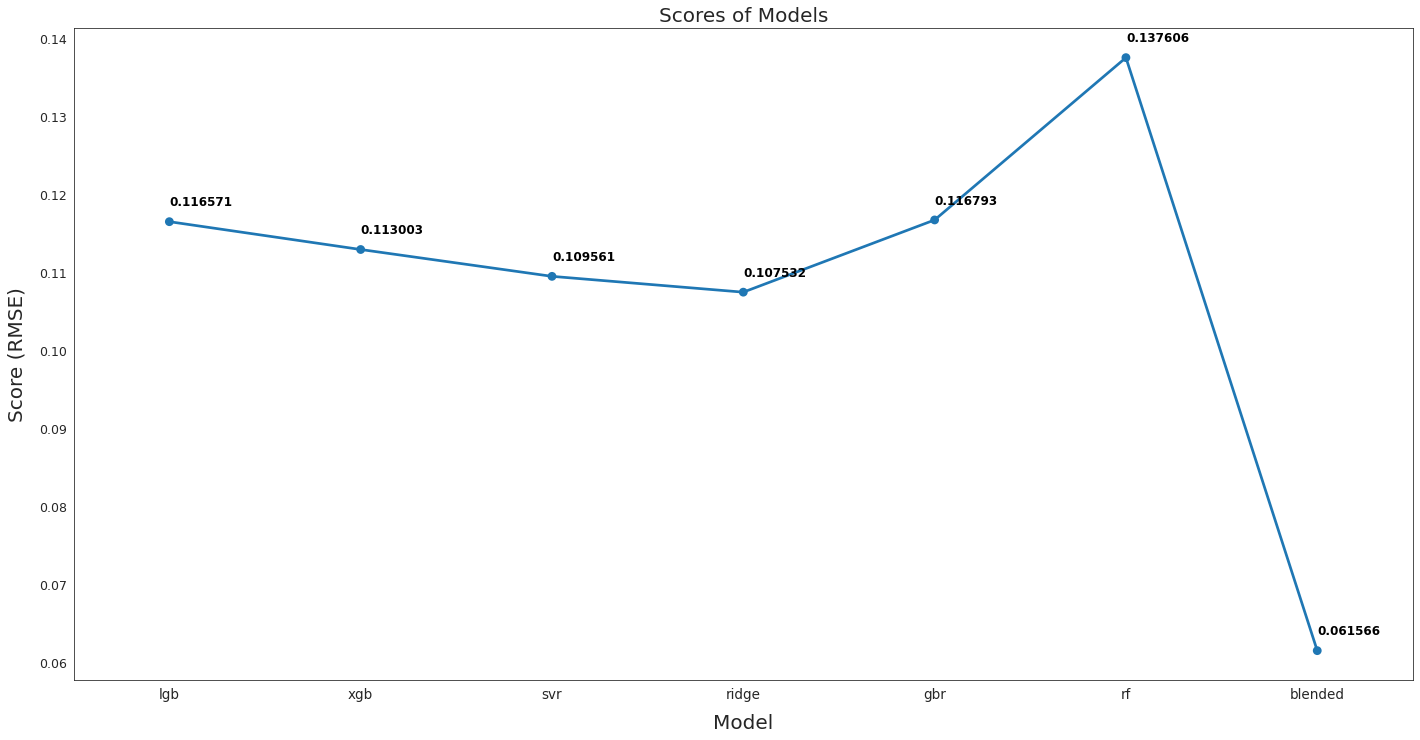

In [44]:
# set up figure
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

# plot points
ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

# edit graph
plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)
plt.title('Scores of Models', size=20)

plt.show()

# Submitting final predictions

In [45]:
predictions = np.floor(np.expm1(blend_models_predict(X_test))) # exponentialise because the predictions are logged
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
output = pd.DataFrame({'Id': test["Id"], 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
